In [1]:
import pandas as pd 
import numpy as np
from pandas_datareader import data, wb
import pandas_datareader as pdr
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import datetime
import math
import stock_cache # local module
fdr.__version__

MOMENTUM_DAYS = 180 # 6개월

now = datetime.datetime.now()
start_time = datetime.datetime(2020, 1, 1, 9, 0, 0)
end_time = datetime.datetime(2021, 9, 5, 9, 0, 0)
#EST = datetime.timezone(datetime.timedelta(hours=-5))
#start_time = datetime.datetime(2020, 1, 1, 9, 0, 0, tzinfo=EST)
#start_time = datetime.datetime.strptime("20200101", "%Y%m%d")
#end_time = datetime.datetime.strptime("20210101", "%Y%m%d")
#start_time = now - datetime.timedelta(weeks=52) # 1년 전으로 start 설정
#end_time = now - datetime.timedelta(weeks=4) # 1달 전으로 end 설정
prev_start_time = start_time - datetime.timedelta(days=MOMENTUM_DAYS)
prev_end_time = start_time - datetime.timedelta(days=1)

'0.9.31'

# 테스트 코드

## Dictionary append

In [53]:
ticker_dict = { }
ticker_dict["005930.KS"] = { "code": "005930.KS", "name": "Samsung"}
for k, v in ticker_dict.items():
    k = code
    print(k, v)

051900.KS {'code': '005930.KS', 'name': 'Samsung'}


## DataFrame append

In [489]:
dates = pd.date_range("20130101", periods=6)
print(type(dates[0]))
df = pd.DataFrame(columns=['A', 'B'])
for i in range(5):
    df = df.append(pd.Series({'A':i, 'B':i}, index=df.columns, name=dates[i]))
df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,A,B
2013-01-01,0,0
2013-01-02,1,1
2013-01-03,2,2
2013-01-04,3,3
2013-01-05,4,4


# 종목 정보 가져오기

In [2]:
std_list = { 
    "KS11": { "stock_name": "KOSPI" },
    "KS200": { "stock_name": "KOSPI200" }
}
system_list = {
}

In [114]:
ticker_list_one = {
    "005930.KS": { "stock_name": "Samsung"}
}
ticker_list_10 = {
    "005930.KS": { "stock_name": "Samsung"},
    "000660.KS": { "stock_name": "SK Hynix"},
    "051910.KS": { "stock_name": "LG화학"},
    "068270.KS": { "stock_name": "셀트리온"},
    "035420.KS": { "stock_name": "Naver"},
    "006400.KS": { "stock_name": "Samsung SDI"},
    "005380.KS": { "stock_name": "Hyundai"},
    "035720.KS": { "stock_name": "Kakao"},
    "036570.KS": { "stock_name": "NCsoft"},
    "051900.KS": { "stock_name": "LG생활건강"}
}
#ticker_list = ticker_list_10.copy()
#del ticker_list['005930.KS']
#ticker_list = ticker_list_10

ticker_exclude_list = []
#ticker_exclude_list = ["105560.KS"] # KB금융 - 2020-04-02 부터 3만원대 -> 3백만원대 -> 파라미터로 전달하지 않더라도 verify 코드에서 걸러냄
ticker_list = stock_cache.get_stock_listing_dict(1000, ticker_exclude_list) # 갯수 만큼 KOSPI 종목 리스트 가져오기
print(len(ticker_list))

In [84]:
# DataFrame
#def get_rate_of_return(x):
#    return round((x.iloc[-1]-x.iloc[0]),2)

def add_relative_value(ticker_data, src_name):
    # 100기준 종가 컬럼 추가
    ticker_data['relative_value'] = ticker_data[src_name] / ticker_data[src_name].iloc[0]*100

def verify_ticker_data(ticker_data):
    # 전일 대시 30% 이상 상승/하락시 에러
    result_filter = abs((ticker_data['Close'] - ticker_data['prev_close01']) / ticker_data['prev_close01'] * 100) > 30
    result_data = ticker_data[result_filter]
    #result_data = ticker_data[abs((ticker_data['Close'] - ticker_data['prev_close01']) / ticker_data['prev_close01'] * 100) > 30]

    if (len(result_data) > 0):
        return False
    return True
    
def get_ticker_data(code, start_time, end_time, use_fdr=False):
    global MOMENTUM_DAYS
    prev_start_time = start_time - datetime.timedelta(days=MOMENTUM_DAYS)
    prev_end_time = start_time - datetime.timedelta(days=1)
    
    # 이전 180일 데이터 조회, 타겟 기간 데이터 조회
    prev_data = stock_cache.get_stock_data_second_half(code, prev_start_time, prev_end_time, use_fdr)
    prev_len = len(prev_data)
    if (prev_len <= 0): # TODO 0보다는 크나 갯수가 충분하지 않으면?
        print("get_ticker_data(): ticker_data not enough", "prev_len)=", prev_len)
        return pd.DataFrame()
    ticker_data = stock_cache.get_stock_data(code, start_time, end_time, use_fdr)
    ticker_len = len(ticker_data)
    if (ticker_len <= 0): # TODO 0보다는 크나 갯수가 충분하지 않으면?
        print("get_ticker_data(): ticker_data not enough", "ticker_len=", ticker_len)
        return pd.DataFrame()
    total_data = pd.concat([prev_data, ticker_data])

    # 1일전 종가 컬럼 추가, 180일전 종가/수익률 컬럼 추가
    start_loc = len(prev_data)-1
    prev_data01 = total_data[start_loc:start_loc+len(ticker_data)]
    prev_data180 = total_data[:len(ticker_data)]
    ticker_data['prev_close01'] = prev_data01['Close'].values
    ticker_data['prev_close180'] = prev_data180['Close'].values
    prev_rate180 = (ticker_data['Close'] - ticker_data['prev_close180'])/ticker_data['prev_close180']*100
    ticker_data['prev_rate180'] = prev_rate180.values
    
    # 100기준 종가 컬럼 추가
    add_relative_value(ticker_data, 'Close')
    #ticker_data['relative_close'] = ticker_data['Close'] / ticker_data['Close'].iloc[0]*100
    
    # 이동평균 컬럼 추가
    ma5 = total_data['Close'].rolling(window=5).mean()
    ma25 = total_data['Close'].rolling(window=25).mean()
    ma50 = total_data['Close'].rolling(window=50).mean()
    ma100 = total_data['Close'].rolling(window=100).mean()
    ticker_data['ma5'] = ma5[prev_len:]
    ticker_data['ma25'] = ma25[prev_len:]
    ticker_data['ma50'] = ma50[prev_len:]
    ticker_data['ma100'] = ma100[prev_len:]
    
    # ATR(Average Trace Range) 추가
    tr = total_data['High'] - total_data['Low']
    ticker_data['tr'] = tr[prev_len:]
    atr20 = tr.rolling(window=20).mean()
    ticker_data['atr20'] = atr20[prev_len:]
    
    if (not verify_ticker_data(ticker_data)):
        print("get_ticker_data(): verify failed", "code=", code)
        return pd.DataFrame()
    return ticker_data

def get_ticker_data_direct(code, start_time, end_time, use_fdr=False):
    global MOMENTUM_DAYS
    prev_start_time = start_time - datetime.timedelta(days=MOMENTUM_DAYS)
    prev_end_time = start_time - datetime.timedelta(days=1)
    
    if (use_fdr):
        prev_data = fdr.DataReader(code, prev_start_time, prev_end_time)
        ticker_data = fdr.DataReader(code, start_time, end_time)
        total_data = pd.concat([prev_data, ticker_data])
    else:
        prev_data = pdr.data.get_data_yahoo(code, prev_start_time, prev_end_time)
        ticker_data = pdr.data.get_data_yahoo(code, start_time, end_time)
        total_data = pd.concat([prev_data, ticker_data])

    # 180일전 종가 컬럼, 180일전 대비 수익율 컬럼 추가
    prev_close180 = total_data[:len(ticker_data)]
    ticker_data['prev_close180'] = prev_close180['Close'].values
    prev_rate180 = (ticker_data['Close'] - ticker_data['prev_close180'])/ticker_data['prev_close180']*100
    ticker_data['prev_rate180'] = prev_rate180.values
    
    # 100기준 종가 컬럼 추가
    add_relative_value(ticker_data, 'Close')
    #ticker_data['relative_close'] = ticker_data['Close'] / ticker_data['Close'].iloc[0]*100
    
    # 이동평균 컬럼 추가
    ma5 = total_data['Close'].rolling(window=5).mean()
    ma25 = total_data['Close'].rolling(window=25).mean()
    ma50 = total_data['Close'].rolling(window=50).mean()
    ma100 = total_data['Close'].rolling(window=100).mean()
    ticker_data['ma5'] = ma5[len(prev_data):]
    ticker_data['ma25'] = ma25[len(prev_data):]
    ticker_data['ma50'] = ma50[len(prev_data):]
    ticker_data['ma100'] = ma100[len(prev_data):]
    return ticker_data

# 차트
def show_chart():
    fig = plt.figure(figsize=(10,5))
    fig.tight_layout()
    subplot = fig.add_subplot(1,1,1)

    for k, v in std_list.items():
        name = v['stock_name']
        ticker_data = v['data']
        subplot.plot(ticker_data['relative_value'], label=name)
        subplot.legend()

    for k, v in ticker_list.items():
        if (k in ["005930.KS"]):
            name = v['stock_name']
            ticker_data = v['data']
            subplot.plot(ticker_data['relative_value'], label=name)
            subplot.legend()

    name = 'LTHM'
    ticker_data = system.data
    subplot.plot(ticker_data['relative_value'], label=name)
    subplot.legend()
    #plt.show()
    return subplot

In [85]:
for k, v in std_list.items():
    code = k
    std_list[code]['data'] = get_ticker_data(code, start_time, end_time, use_fdr=True)

In [115]:
for k in list(ticker_list.keys()): # list 없으면 에러 발생 - dictionary changed size during iteration
    code = k
    stock_name = ticker_list[code]['stock_name']
    ticker_data = get_ticker_data(code, start_time, end_time)
    ticker_list[code]['data'] = ticker_data
    if (len(ticker_data) <= 0):
        print("ticker_data not enough, remove:", "code=", code, "stock_name=", stock_name)
        del ticker_list[code]

get_ticker_data(): verify failed code= 000210.KS
ticker_data not enough, remove: code= 000210.KS stock_name= DL
get_ticker_data(): ticker_data not enough prev_len)= 0
ticker_data not enough, remove: code= 375500.KS stock_name= DL이앤씨
get_ticker_data(): ticker_data not enough prev_len)= 0
ticker_data not enough, remove: code= 365550.KS stock_name= ESR켄달스퀘어리츠
get_ticker_data(): ticker_data not enough prev_len)= 0
ticker_data not enough, remove: code= 383220.KS stock_name= F&F
get_ticker_data(): verify failed code= 105560.KS
ticker_data not enough, remove: code= 105560.KS stock_name= KB금융
get_ticker_data(): ticker_data not enough prev_len)= 0
ticker_data not enough, remove: code= 344820.KS stock_name= KCC글라스
get_ticker_data(): ticker_data not enough prev_len)= 0
ticker_data not enough, remove: code= 383800.KS stock_name= LX홀딩스
get_ticker_data(): ticker_data not enough prev_len)= 0
ticker_data not enough, remove: code= 302440.KS stock_name= SK바이오사이언스
get_ticker_data(): ticker_data not enoug

## 주가 정보 조회

In [68]:
code = 'KS200'
ticker_data = get_ticker_data(code, start_time, end_time, use_fdr=True)
ticker_data.head()

Close             2.903500e+02
Open              2.941900e+02
High              2.945700e+02
Low               2.899600e+02
Volume            6.616000e+07
Change           -1.160000e-02
prev_close01      2.952000e+02
prev_close180     2.723700e+02
prev_rate180      6.601314e+00
relative_value    1.000000e+02
ma5               2.934760e+02
ma25              2.852296e+02
ma50              2.829260e+02
ma100             2.738723e+02
Name: 2020-01-02 00:00:00, dtype: float64

In [87]:
code = '005930.KS'
#code = '051910.KS'
ticker_data = get_ticker_data(code, start_time, end_time)
ticker_data.head()

,High,Low,Open,Close,Volume,Adj Close,prev_close01,prev_close180,prev_rate180,relative_value,ma5,ma25,ma50,ma100,tr,atr20
2020-01-02,56000,55000,55500,55200,12993228,52305.605469,56500,46250,19.351351,100.000000,55520.0,53078.0,52417.0,49350.0,1000,985.0
2020-01-03,56600,54900,56000,55500,15422255,52589.875000,55200,45400,22.246696,100.543478,55520.0,53226.0,52529.0,49455.5,1700,1025.0
2020-01-06,55600,54600,54900,55500,10278951,52589.875000,55500,46000,20.652174,100.543478,55620.0,53374.0,52633.0,49571.0,1000,1035.0
2020-01-07,56400,55600,55700,55800,10009778,52874.144531,55500,45650,22.234392,101.086957,55700.0,53518.0,52725.0,49694.0,800,1032.5
2020-01-08,57400,55900,56200,56800,23501171,53821.703125,55800,44400,27.927928,102.898551,55760.0,53738.0,52837.0,49830.0,1500,1062.5


In [ ]:
ticker_data.loc['2020-01-02']
ticker_data["2020-01-02":"2020-01-05"]

## 180일 수익률 차트

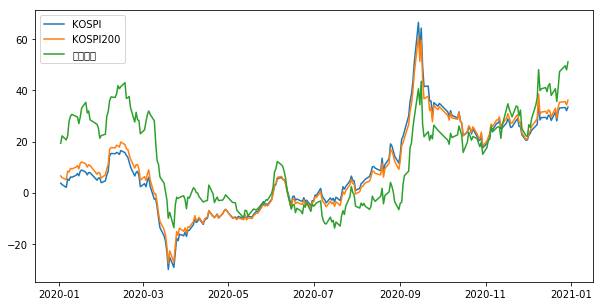

In [12]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)

for k, v in std_list.items():
    name = v['stock_name']
    ticker_data = v['data']
    subplot.plot(ticker_data['prev_rate180'], label=name)
    subplot.legend()
for k, v in ticker_list.items():
    if (k in ["005930.KS"]):
        name = v['stock_name']
        ticker_data = v['data']
        subplot.plot(ticker_data['prev_rate180'], label=name)
        subplot.legend()
plt.show()

## 100기준 수익률 차트

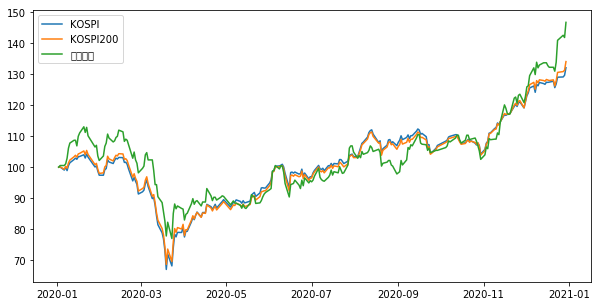

In [34]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)

for k, v in std_list.items():
    name = v['stock_name']
    ticker_data = v['data']
    subplot.plot(ticker_data['relative_value'], label=name)
    subplot.legend()
for k, v in ticker_list.items():
    if (k in ["005930.KS"]):
        name = v['stock_name']
        ticker_data = v['data']
        subplot.plot(ticker_data['relative_value'], label=name)
        subplot.legend()
plt.show()

## 개별 종목 가격, 이동평균 차트

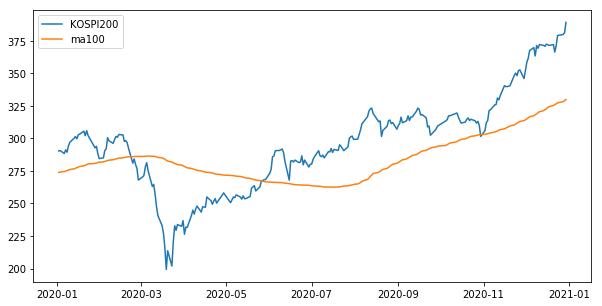

In [19]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)
    
code = "KS200"
ticker_data = std_list[code]['data']
subplot.plot(ticker_data['Close'], label=std_list[code]['stock_name'])
#subplot.plot(ticker_data['ma5'], label='ma5')
#subplot.plot(ticker_data['ma25'], label='ma25')
#subplot.plot(ticker_data['ma50'], label='ma50')
subplot.plot(ticker_data['ma100'], label='ma100')
subplot.legend()
plt.show()

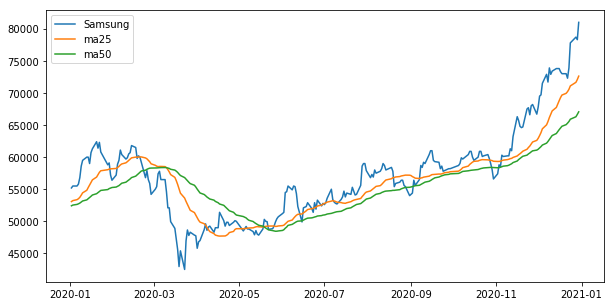

In [20]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)
    
code = "005930.KS"
ticker_data = ticker_list[code]['data']
subplot.plot(ticker_data['Close'], label=ticker_list[code]['stock_name'])
#subplot.plot(ticker_data['ma5'], label='ma5')
subplot.plot(ticker_data['ma25'], label='ma25')
subplot.plot(ticker_data['ma50'], label='ma50')
#subplot.plot(ticker_data['ma100'], label='ma100')
subplot.legend()
plt.show()

,High,Low,Open,Close,Volume,Adj Close,prev_close01,prev_close180,prev_rate180,relative_value,ma5,ma25,ma50,ma100
2020-01-02,2185,2130,2135,2180,131658,2180,2115,2700,-19.259259,100.000000,2111.0,2144.8,2209.3,2191.4
2020-01-03,2190,2145,2160,2160,107168,2160,2180,2700,-20.000000,99.082569,2121.0,2143.2,2206.8,2192.1


# 자산 관리 - 종목 매수, 매도

In [146]:
class Stock:
    def __init__(self, code):
        self.code = code
        self.stock_name = stock_cache.get_stock_name(code)
        self.count = 0
        self.buy_price = 0
        self.buy_atr20 = 0
        self.highest_price = 0
        self.price = 0 # current price
        self.ammount = 0
        
    def get_profit_percent(self):
        p = (self.price-self.buy_price)/self.buy_price*100
        return round(p, 2)
    
    def get_profit_amount(self):
        return self.amount - self.buy_price*self.count
        
    def buy(self, count, price, atr20):
        self.count += count
        self.buy_price = price
        self.buy_atr20 = atr20
        self.price = price
        self.apply(price)
        
    def sell(self, count, price):
        self.count -= count
        self.price = price
        self.apply(price)
        
    def apply(self, price):
        self.price = price
        if (price > self.highest_price):
            self.highest_price = price
        self.amount = self.count * self.price
        
class Asset:
    def __init__(self, cash):
        self.stocks = { }
        self.cash = cash
        self.total = cash
    
    def get_stock_count(self):
        return len(self.stocks)
    
    def buy(self, code, count, price, atr20):
        stock = self.get_stock(code)
        
        amount = count * price
        self.cash -= amount # TODO cash 부족시
        stock.buy(count, price, atr20)
        self.eval()
        
    def get_buy_count(self, price):
        count = math.floor(self.cash / price)
        return count
    
    def sell(self, code, price):
        if (not self.is_stock(code)):
            print("Asset.sell(): stock not exist", code)
            return

        stock = self.get_stock(code)
        count = stock.count
        amount = count * price
        stock.sell(count, price)
        self.cash += amount
        
        if (stock.count == 0):
            del self.stocks[code]
        self.eval()
    
    def apply(self, code, price):
        if (self.is_stock(code)):
            stock = self.get_stock(code)
            stock.apply(price)
            self.eval()
        
    def get_stock(self, code):
        if code in self.stocks:
            return self.stocks[code]
        else:
            stock = Stock(code)
            self.stocks[code] = stock;
            return stock
        
    def is_stock(self, code):
        if code in self.stocks:
            return True
        return False
        
    def eval(self):
        stock_total = 0
        for k, v in self.stocks.items():
            stock_total += v.amount
        self.total = stock_total + self.cash
        return self.total
    
    def display(self):
        print("Asset.display():", "total=", self.total, "cash=", self.cash)
        for k, v in self.stocks.items():
            print("    ", "code=", v.code, "stock_name=", v.stock_name, \
                  "count=", v.count, "price=", v.price, "amount=", v.amount, \
                  "highest_price=", v.highest_price, \
                  "profit_percent=", v.get_profit_percent())


In [147]:
code = "005930.KS"
asset = Asset(10000000)
asset.buy(code, 10, 70000, 1000)
asset.apply(code, 80000)
asset.sell(code, 90000)
asset.display()

Asset.display(): total= 10200000 cash= 10200000


# 종목 이벤트 이력

In [56]:
UNKNOWN_TREND = 0
DOWN_TREND = -1
UP_TREND = 1
class StockHistory:
    def __init__(self, code):
        self.code = code
        self.name = stock_cache.get_stock_name(code)
        self.trend = UNKNOWN_TREND
        self.event_histories = [ ]

class StockHistoryStore:
    def __init__(self):
        self.stock_histories = { }
        
    def get_stock_history(self, code):
        if code in self.stock_histories:
            return self.stock_histories[code]
        else:
            stock_history = StockHistory(code)
            self.stock_histories[code] = stock_history;
            return stock_history

# 시스템

In [11]:
batch_data = pd.DataFrame()
idx = '2020-01-02'
for k, v in ticker_list.items():
    copy = v['data'].loc[idx].copy() # ticker_data
    copy['code'] = k
    batch_data = batch_data.append(copy)
batch_filtered_data = batch_data[batch_data.ma25 > batch_data.ma50]
batch_filtered_data.sort_values(by='prev_rate180', ascending=False)

,Adj Close,Close,High,Low,Open,Volume,code,ma100,ma25,ma5,ma50,prev_close180,prev_rate180,relative_value
2020-01-02,1.822389e+05,182500.0,188000.0,182000.0,187500.0,300640.0,035420.KS,159410.0,176600.0,182500.0,169080.0,115000.0,58.695652,100.0
2020-01-02,9.374070e+04,94700.0,96200.0,94100.0,96000.0,2342070.0,000660.KS,81370.0,86276.0,94780.0,84248.0,71400.0,32.633053,100.0
2020-01-02,5.230561e+04,55200.0,56000.0,55000.0,55500.0,12993228.0,005930.KS,49350.0,53078.0,55520.0,52417.0,46250.0,19.351351,100.0
2020-01-02,3.048773e+04,30500.0,30900.0,30400.0,30800.0,1205235.0,035720.KS,28270.0,30480.0,29960.0,29916.0,26300.0,15.969582,100.0
2020-01-02,1.257498e+06,1266000.0,1272000.0,1249000.0,1254000.0,24426.0,051900.KS,1243300.0,1265920.0,1260400.0,1256440.0,1276000.0,-0.783699,100.0


In [585]:
code = "005930.KS"
idx = '2020-01-02'
ticker_data = ticker_list[code]['data']
ticker_data.loc[idx]

High              5.600000e+04
Low               5.500000e+04
Open              5.550000e+04
Close             5.520000e+04
Volume            1.299323e+07
Adj Close         5.230561e+04
prev_close180     4.565000e+04
prev_rate180      2.092004e+01
relative_value    1.000000e+02
ma5               5.558000e+04
ma25              5.323800e+04
ma50              5.253500e+04
ma100             4.945850e+04
Name: 2020-01-02 00:00:00, dtype: float64

In [155]:
class LTHM: # LongTrendHighMomentum
    def __init__(self, max_position=10, max_percent=10, cash=100000000): # 1억원
        self.MAX_POSITION = max_position # 최대 종목 갯수
        self.MAX_PERCENT = max_percent # 전체 자산 대비 종목별 최대 비중
        self.RISK_PERCENT = 2 # 손실 위험
        self.MIN_TRADING_AMOUNT = 60 * 1000 * 1000 * 1200 # 6백억
        self.MIN_PRICE = 6000 # 6천
        self.ATR_MULTIPLY = 1 # stop loss=ATR*ATR_MULTIPLY
        self.PROFIT_RESERVE_PERCENT = 10
        self.stock_history_store = StockHistoryStore()
        self.asset = Asset(cash)
        self.data = pd.DataFrame(columns=['total', 'cash'])
        self.action_histories = [ ]
    
    # 모든 종목에 대해 idx row를 합쳐 batch_data 생성
    def make_batch_data(self, idx):
        batch_data = pd.DataFrame()
        for k, v in ticker_list.items():
            if (idx in v['data'].index):
                copy = v['data'].loc[idx].copy()
                copy['code'] = k
                batch_data = batch_data.append(copy)
        return batch_data
    
    def filter_batch_data(self, batch_data):  
        if (len(batch_data) == 0):
            return batch_data
        
        filtered_data = batch_data[\
            (batch_data['Close']*batch_data['Volume'] > self.MIN_TRADING_AMOUNT) &\
            (batch_data['Close'] > self.MIN_PRICE) &\
            (batch_data.ma25 > batch_data.ma50)]
        return filtered_data

        # 종목 거래 금액 filter - 500억 # TODO 20일 기준 일평균 거래 금액 사용
        #new_data = batch_data[batch_data['Close']*batch_data['Volume'] > 50000000000]
        # 종목 주가 filter - 5천원
        #new_data = batch_data[batch_data['Close'] > 5000]
        # 종목 이동 평균 filter
        #new_data = batch_data[batch_data.ma25 > batch_data.ma50]
        #return new_data
    
    def prioritize_batch_data(self, batch_data):
        return batch_data.sort_values(by='prev_rate180', ascending=False)
    
    def backtest(self):
        ticker_data = std_list['KS11']['data'] # idx 가져오기 위해 지수 종목 사용
        for idx, row in ticker_data.iterrows():
            self.apply(idx)
        
        add_relative_value(self.data, 'total') # total 값을 이용하여 relative_value 컬럼 추가
        return
    
    def apply(self, idx):       
        # 신규 종목 체크
        if (self.get_available_position_count() > 0):
            batch_data = self.make_batch_data(idx)
            batch_data = self.filter_batch_data(batch_data)
            batch_data = self.prioritize_batch_data(batch_data)
            #print("LTHM.apply():", "idx=", idx, "batch_data_len=", len(batch_data))
            for idx, row in batch_data.iterrows():
                code = row['code']
                self.apply_stock(code, idx, row)
  
        # 보유 종목 체크
        for k in list(self.asset.stocks.keys()):
            code = k
            ticker_data = ticker_list[code]['data']
            row = ticker_data.loc[idx]
            self.apply_stock(code, idx, row)

        self.data = self.data.append(pd.Series({'total':self.asset.total, 'cash':self.asset.cash}, index=self.data.columns, name=idx))
        
    def apply_stock(self, code, idx, row):
        stock_history = self.stock_history_store.get_stock_history(code)
        price = row['Close']
        atr20 = row['atr20']
        self.asset.apply(code, price)
        
        if (not self.asset.is_stock(code) and \
            self.is_ks200_satisfied(idx) and \
            self.is_uptrend(stock_history, idx, row)):
            count = self.get_buy_count(price)
            if (count > 0):
                action = { "name": "buy", "idx": idx.strftime('%Y-%m-%d'), "code": code, "stock_name": stock_history.name, "count": count, "price": price}
                print("action:", action)
                self.asset.buy(code, count, price, atr20)
                self.asset.display()
                self.action_histories.append(action)
        if (self.asset.is_stock(code)):
            stock = self.asset.get_stock(code)
            count = stock.count
            if (self.is_stop_loss(stock, row) or \
               self.is_profit_reserve(stock, row)):
                self.asset.sell(code, price)
                action = {"name": "sell", \
                          "idx": idx.strftime('%Y-%m-%d'), \
                          "code": code, \
                          "stock_name": stock_history.name, \
                          "count": count, \
                          "price": price, \
                          "buy_price": stock.buy_price, \
                          "profit_percent": stock.get_profit_percent()}
                print("action:", action)
                self.asset.display()
                self.action_histories.append(action)

    def is_ks200_satisfied(self, idx):
        code = "KS200"
        ticker_data = std_list[code]['data']
        row = ticker_data.loc[idx]
        if (row['Close'] > row['ma100']):
            return True
        return False
            
    def get_buy_count(self, price):
        available_position_count = self.get_available_position_count()
#        stock_count = self.asset.get_stock_count()
#        remain_position_count = self.MAX_POSITION - stock_count
        print("LTHM.get_buy_count():", "cash=", self.asset.cash, "available_position_count=", available_position_count)
        
        if (available_position_count < 1):
            return 0
        position_cash = self.asset.cash / available_position_count
        position_limit = self.asset.total * self.MAX_PERCENT / 100
        print("LTHM.get_buy_count():", "position_cash=", position_cash, "position_limit=", position_limit)
        if (position_cash > position_limit):
            position_cash = position_limit
        return math.floor(position_cash / price)
    
    def get_available_position_count(self):
        return self.MAX_POSITION - self.asset.get_stock_count()
    
    def is_uptrend(self, stock_history, idx, row):
        if (row['ma25'] > row['ma50']):
            stock_history.trend = UP_TREND
            return True
        return False        

    def is_downtrend(self, stock_history, idx, row):
        if (row['ma25'] < row['ma50']):
            stock_history.trend = DOWN_TREND
            return True
        return False
    
    def is_stop_loss(self, stock, row):
        price = row['Close']
        if (price < stock.buy_price and ((stock.buy_price-price) > stock.buy_atr20*self.ATR_MULTIPLY)):
            print("LTHM.is_stop_loss():", "code=", stock.code, "stock_name=", stock.stock_name, \
                  "buy_price=", stock.buy_price, "price=", price, "buy_atr20=", stock.buy_atr20)
            return True
        return False

    def is_profit_reserve(self, stock, row):
        price = row['Close']
        if (price < stock.highest_price*(1-self.PROFIT_RESERVE_PERCENT/100)):
            print("LTHM.is_profit_reserve():", "code=", stock.code, "stock_name=", stock.stock_name, \
                  "buy_price=", stock.buy_price, "price=", price, "highest_price=", stock.highest_price)
            return True
        return False
    
    def on_gold_cross(self, stock_history, idx, row):
        code = stock_history.code
        stock_name = stock_history.name
        if (stock_history.trend != UP_TREND and row['ma25'] > row['ma50']):
            stock_history.trend = UP_TREND
            event = { "idx": idx.strftime('%Y-%m-%d'), "code": code, "stock_name": stock_name, "name": "uptrend"}
            stock_history.event_histories.append(event)
            print("event:", event)
            return True
        return False
    
    def on_dead_cross(self, stock_history, idx, row):
        code = stock_history.code
        stock_name = stock_history.name
        if (stock_history.trend != DOWN_TREND and row['ma25'] < row['ma50']):
            stock_history.trend = DOWN_TREND
            event = { "idx": idx.strftime('%Y-%m-%d'), "code": code, "stock_name": stock_name, "name": "downtrend"}
            stock_history.event_histories.append(event)
            print("event:", event)
            return True
        return False


## 시스템 - position=1

In [ ]:
#ticker_list = ticker_list_one.copy()
system = LTHM(max_position=1, max_percent=100)
system.backtest()
#system.action_histories

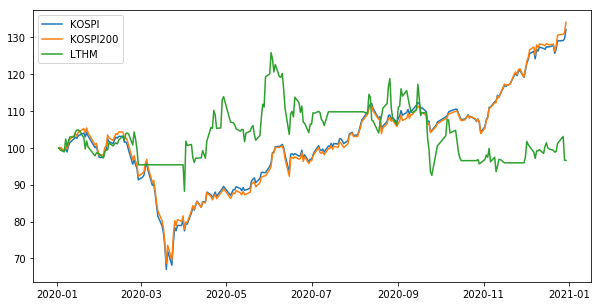

In [76]:
show_chart()

## 시스템 - position=3

In [ ]:
#ticker_list = ticker_list_two.copy()
system = LTHM(max_position=3, max_percent=33)
system.backtest()
#system.apply('2020-01-02')
#system.apply('2020-01-03')
#system.action_histories

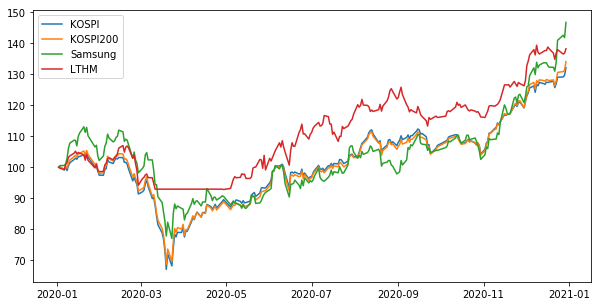

In [31]:
show_chart()

## 시스템 - position=10

In [156]:
system = LTHM(max_position=10, max_percent=10)
system.backtest()

LTHM.get_buy_count(): cash= 100000000 available_position_count= 10
LTHM.get_buy_count(): position_cash= 10000000.0 position_limit= 10000000.0
action: {'name': 'buy', 'idx': '2020-01-02', 'code': '000660.KS', 'stock_name': 'SK하이닉스', 'count': 105, 'price': 94700.0}
Asset.display(): total= 100000000.0 cash= 90056500.0
     code= 000660.KS stock_name= SK하이닉스 count= 105 price= 94700.0 amount= 9943500.0 highest_price= 94700.0 profit_percent= 0.0
LTHM.get_buy_count(): cash= 90056500.0 available_position_count= 9
LTHM.get_buy_count(): position_cash= 10006277.777777778 position_limit= 10000000.0
action: {'name': 'buy', 'idx': '2020-01-02', 'code': '005930.KS', 'stock_name': '삼성전자', 'count': 181, 'price': 55200.0}
Asset.display(): total= 100000000.0 cash= 80065300.0
     code= 000660.KS stock_name= SK하이닉스 count= 105 price= 94700.0 amount= 9943500.0 highest_price= 94700.0 profit_percent= 0.0
     code= 005930.KS stock_name= 삼성전자 count= 181 price= 55200.0 amount= 9991200.0 highest_price= 55200.0 p

LTHM.get_buy_count(): cash= 7938350.0 available_position_count= 1
LTHM.get_buy_count(): position_cash= 7938350.0 position_limit= 9984495.0
action: {'name': 'buy', 'idx': '2020-01-10', 'code': '004770.KS', 'stock_name': '써니전자', 'count': 1320, 'price': 6010.0}
Asset.display(): total= 99844950.0 cash= 5150.0
     code= 000660.KS stock_name= SK하이닉스 count= 105 price= 99000.0 amount= 10395000.0 highest_price= 99000.0 profit_percent= 4.54
     code= 005930.KS stock_name= 삼성전자 count= 181 price= 58600.0 amount= 10606600.0 highest_price= 58600.0 profit_percent= 6.16
     code= 008770.KS stock_name= 호텔신라 count= 106 price= 99400.0 amount= 10536400.0 highest_price= 99400.0 profit_percent= 5.74
     code= 035420.KS stock_name= NAVER count= 55 price= 186000.0 amount= 10230000.0 highest_price= 187000.0 profit_percent= 2.48
     code= 009150.KS stock_name= 삼성전기 count= 78 price= 132000.0 amount= 10296000.0 highest_price= 132000.0 profit_percent= 3.53
     code= 035720.KS stock_name= 카카오 count= 312 price

LTHM.get_buy_count(): cash= 8520.0 available_position_count= 0
LTHM.get_buy_count(): cash= 8520.0 available_position_count= 0
LTHM.is_stop_loss(): code= 051900.KS stock_name= LG생활건강 buy_price= 1343000.0 price= 1253000.0 buy_atr20= 24400.0
action: {'name': 'sell', 'idx': '2020-01-28', 'code': '051900.KS', 'stock_name': 'LG생활건강', 'count': 7, 'price': 1253000.0, 'buy_price': 1343000.0, 'profit_percent': -6.7}
Asset.display(): total= 96799250.0 cash= 8779520.0
     code= 000660.KS stock_name= SK하이닉스 count= 105 price= 96300.0 amount= 10111500.0 highest_price= 101000.0 profit_percent= 1.69
     code= 005930.KS stock_name= 삼성전자 count= 181 price= 58800.0 amount= 10642800.0 highest_price= 62400.0 profit_percent= 6.52
     code= 035420.KS stock_name= NAVER count= 55 price= 178500.0 amount= 9817500.0 highest_price= 191500.0 profit_percent= -1.65
     code= 009150.KS stock_name= 삼성전기 count= 78 price= 131000.0 amount= 10218000.0 highest_price= 137000.0 profit_percent= 2.75
     code= 035720.KS stoc

LTHM.is_stop_loss(): code= 006400.KS stock_name= 삼성SDI buy_price= 285000.0 price= 276000.0 buy_atr20= 7375.0
action: {'name': 'sell', 'idx': '2020-01-31', 'code': '006400.KS', 'stock_name': '삼성SDI', 'count': 22, 'price': 276000.0, 'buy_price': 285000.0, 'profit_percent': -3.16}
Asset.display(): total= 93063520.0 cash= 15989320.0
     code= 000660.KS stock_name= SK하이닉스 count= 105 price= 93500.0 amount= 9817500.0 highest_price= 101000.0 profit_percent= -1.27
     code= 005930.KS stock_name= 삼성전자 count= 181 price= 56400.0 amount= 10208400.0 highest_price= 62400.0 profit_percent= 2.17
     code= 035420.KS stock_name= NAVER count= 55 price= 179500.0 amount= 9872500.0 highest_price= 191500.0 profit_percent= -1.1
     code= 009150.KS stock_name= 삼성전기 count= 78 price= 125000.0 amount= 9750000.0 highest_price= 137000.0 profit_percent= -1.96
     code= 035720.KS stock_name= 카카오 count= 312 price= 32400.0 amount= 10108800.0 highest_price= 34300.0 profit_percent= 1.25
     code= 005490.KS stock_nam

LTHM.get_buy_count(): cash= 8926044.84375 available_position_count= 1
LTHM.get_buy_count(): position_cash= 8926044.84375 position_limit= 9519452.921875
action: {'name': 'buy', 'idx': '2020-02-05', 'code': '026890.KS', 'stock_name': '디피씨', 'count': 1219, 'price': 7320.0}
Asset.display(): total= 95194529.21875 cash= 2964.84375
     code= 000660.KS stock_name= SK하이닉스 count= 105 price= 97100.0 amount= 10195500.0 highest_price= 101000.0 profit_percent= 2.53
     code= 005930.KS stock_name= 삼성전자 count= 181 price= 58900.0 amount= 10660900.0 highest_price= 62400.0 profit_percent= 6.7
     code= 035420.KS stock_name= NAVER count= 55 price= 180500.0 amount= 9927500.0 highest_price= 191500.0 profit_percent= -0.55
     code= 009150.KS stock_name= 삼성전기 count= 78 price= 134000.0 amount= 10452000.0 highest_price= 137000.0 profit_percent= 5.1
     code= 035720.KS stock_name= 카카오 count= 312 price= 32900.0 amount= 10264800.0 highest_price= 34300.0 profit_percent= 2.81
     code= 207940.KS stock_name= 삼성

LTHM.is_profit_reserve(): code= 000660.KS stock_name= SK하이닉스 buy_price= 94700.0 price= 92800.0 highest_price= 105000.0
action: {'name': 'sell', 'idx': '2020-02-27', 'code': '000660.KS', 'stock_name': 'SK하이닉스', 'count': 105, 'price': 92800.0, 'buy_price': 94700.0, 'profit_percent': -2.01}
Asset.display(): total= 96517207.03125 cash= 28620914.84375
     code= 005930.KS stock_name= 삼성전자 count= 181 price= 56500.0 amount= 10226500.0 highest_price= 62400.0 profit_percent= 2.36
     code= 035420.KS stock_name= NAVER count= 55 price= 187000.0 amount= 10285000.0 highest_price= 191500.0 profit_percent= 3.03
     code= 009150.KS stock_name= 삼성전기 count= 78 price= 131500.0 amount= 10257000.0 highest_price= 146000.0 profit_percent= 3.14
     code= 035720.KS stock_name= 카카오 count= 312 price= 35700.0 amount= 11138400.0 highest_price= 38100.0 profit_percent= 11.56
     code= 051910.KS stock_name= LG화학 count= 23 price= 395000.0 amount= 9085000.0 highest_price= 419500.0 profit_percent= 17.04
     code= 0

Asset.display(): total= 93224160.15625 cash= 18787940.15625
     code= 005690.KS stock_name= 파미셀 count= 393 price= 23700.0 amount= 9314100.0 highest_price= 23700.0 profit_percent= 0.0
     code= 180640.KS stock_name= 한진칼 count= 104 price= 89200.0 amount= 9276800.0 highest_price= 89200.0 profit_percent= 0.0
     code= 026890.KS stock_name= 디피씨 count= 770 price= 12100.0 amount= 9317000.0 highest_price= 12100.0 profit_percent= 0.0
     code= 008350.KS stock_name= 남선알미늄 count= 1403 price= 6640.0 amount= 9315920.0 highest_price= 6640.0 profit_percent= 0.0
     code= 017180.KS stock_name= 명문제약 count= 1210 price= 7700.0 amount= 9317000.0 highest_price= 7700.0 profit_percent= 0.0
     code= 035720.KS stock_name= 카카오 count= 178 price= 52100.0 amount= 9273800.0 highest_price= 52100.0 profit_percent= 0.0
     code= 000990.KS stock_name= DB하이텍 count= 304 price= 30600.0 amount= 9302400.0 highest_price= 30600.0 profit_percent= 0.0
     code= 000910.KS stock_name= 유니온 count= 1320 price= 7060.0 amount

LTHM.get_buy_count(): cash= 25720070.15625 available_position_count= 3
LTHM.get_buy_count(): position_cash= 8573356.71875 position_limit= 8961532.015625
action: {'name': 'buy', 'idx': '2020-06-01', 'code': '003000.KS', 'stock_name': '부광약품', 'count': 345, 'price': 24818.181640625}
Asset.display(): total= 89615320.15625 cash= 17157797.490234375
     code= 005690.KS stock_name= 파미셀 count= 393 price= 23500.0 amount= 9235500.0 highest_price= 24100.0 profit_percent= -0.84
     code= 180640.KS stock_name= 한진칼 count= 104 price= 91100.0 amount= 9474400.0 highest_price= 93300.0 profit_percent= 2.13
     code= 035720.KS stock_name= 카카오 count= 178 price= 52700.0 amount= 9380600.0 highest_price= 53400.0 profit_percent= 1.15
     code= 207940.KS stock_name= 삼성바이오로직스 count= 14 price= 622000.0 amount= 8708000.0 highest_price= 624000.0 profit_percent= -0.32
     code= 006400.KS stock_name= 삼성SDI count= 25 price= 359000.0 amount= 8975000.0 highest_price= 365000.0 profit_percent= -1.64
     code= 019170.

LTHM.is_stop_loss(): code= 005690.KS stock_name= 파미셀 buy_price= 23700.0 price= 21900.0 buy_atr20= 1722.5
action: {'name': 'sell', 'idx': '2020-06-04', 'code': '005690.KS', 'stock_name': '파미셀', 'count': 393, 'price': 21900.0, 'buy_price': 23700.0, 'profit_percent': -7.59}
Asset.display(): total= 87609788.15429688 cash= 34015707.177734375
     code= 180640.KS stock_name= 한진칼 count= 104 price= 89500.0 amount= 9308000.0 highest_price= 93300.0 profit_percent= 0.34
     code= 207940.KS stock_name= 삼성바이오로직스 count= 14 price= 626000.0 amount= 8764000.0 highest_price= 629000.0 profit_percent= 0.32
     code= 006400.KS stock_name= 삼성SDI count= 25 price= 366000.0 amount= 9150000.0 highest_price= 370000.0 profit_percent= 0.27
     code= 007570.KS stock_name= 일양약품 count= 187 price= 50000.0 amount= 9350000.0 highest_price= 50000.0 profit_percent= 4.17
     code= 003000.KS stock_name= 부광약품 count= 345 price= 24772.7265625 amount= 8546590.6640625 highest_price= 25000.0 profit_percent= -0.18
     code= 0

     code= 068270.KS stock_name= 셀트리온 count= 38 price= 282352.9375 amount= 10729411.625 highest_price= 282352.9375 profit_percent= 26.59
     code= 005070.KS stock_name= 코스모신소재 count= 632 price= 12800.0 amount= 8089600.0 highest_price= 13600.0 profit_percent= -4.83
     code= 036570.KS stock_name= 엔씨소프트 count= 10 price= 825000.0 amount= 8250000.0 highest_price= 825000.0 profit_percent= 3.12
     code= 035720.KS stock_name= 카카오 count= 172 price= 53000.0 amount= 9116000.0 highest_price= 53000.0 profit_percent= 4.33
     code= 035420.KS stock_name= NAVER count= 37 price= 240500.0 amount= 8898500.0 highest_price= 244000.0 profit_percent= 3.44
LTHM.get_buy_count(): cash= 12984707.177734375 available_position_count= 1
LTHM.get_buy_count(): position_cash= 12984707.177734375 position_limit= 10098087.611132812
action: {'name': 'buy', 'idx': '2020-06-15', 'code': '019170.KS', 'stock_name': '신풍제약', 'count': 294, 'price': 34300.0}
Asset.display(): total= 100980876.11132812 cash= 2900507.177734375


LTHM.is_stop_loss(): code= 019170.KS stock_name= 신풍제약 buy_price= 34300.0 price= 31700.0 buy_atr20= 2150.0
action: {'name': 'sell', 'idx': '2020-06-16', 'code': '019170.KS', 'stock_name': '신풍제약', 'count': 294, 'price': 31700.0, 'buy_price': 34300.0, 'profit_percent': -7.58}
Asset.display(): total= 95040013.1328125 cash= 27166807.177734375
     code= 207940.KS stock_name= 삼성바이오로직스 count= 14 price= 808000.0 amount= 11312000.0 highest_price= 808000.0 profit_percent= 29.49
     code= 003000.KS stock_name= 부광약품 count= 345 price= 32590.908203125 amount= 11243863.330078125 highest_price= 35409.08984375 profit_percent= 31.32
     code= 068270.KS stock_name= 셀트리온 count= 38 price= 268627.4375 amount= 10207842.625 highest_price= 291666.65625 profit_percent= 20.44
     code= 036570.KS stock_name= 엔씨소프트 count= 10 price= 810000.0 amount= 8100000.0 highest_price= 825000.0 profit_percent= 1.25
     code= 035720.KS stock_name= 카카오 count= 172 price= 50500.0 amount= 8686000.0 highest_price= 53200.0 profit

LTHM.get_buy_count(): cash= 11481452.517578125 available_position_count= 1
LTHM.get_buy_count(): position_cash= 11481452.517578125 position_limit= 9984356.532617187
action: {'name': 'buy', 'idx': '2020-06-23', 'code': '019170.KS', 'stock_name': '신풍제약', 'count': 332, 'price': 30000.0}
Asset.display(): total= 99843565.32617188 cash= 1521452.517578125
     code= 207940.KS stock_name= 삼성바이오로직스 count= 14 price= 793000.0 amount= 11102000.0 highest_price= 826000.0 profit_percent= 27.08
     code= 068270.KS stock_name= 셀트리온 count= 38 price= 291176.46875 amount= 11064705.8125 highest_price= 291666.65625 profit_percent= 30.55
     code= 036570.KS stock_name= 엔씨소프트 count= 10 price= 888000.0 amount= 8880000.0 highest_price= 888000.0 profit_percent= 11.0
     code= 035720.KS stock_name= 카카오 count= 172 price= 54800.0 amount= 9425600.0 highest_price= 54800.0 profit_percent= 7.87
     code= 035420.KS stock_name= NAVER count= 37 price= 270000.0 amount= 9990000.0 highest_price= 270000.0 profit_percent= 

LTHM.get_buy_count(): cash= 14045629.240234375 available_position_count= 1
LTHM.get_buy_count(): position_cash= 14045629.240234375 position_limit= 12093746.761523437
action: {'name': 'buy', 'idx': '2020-07-15', 'code': '003000.KS', 'stock_name': '부광약품', 'count': 374, 'price': 32318.181640625}
Asset.display(): total= 120937467.61523438 cash= 1958629.306640625
     code= 068270.KS stock_name= 셀트리온 count= 38 price= 317647.0625 amount= 12070588.375 highest_price= 322549.03125 profit_percent= 42.42
     code= 036570.KS stock_name= 엔씨소프트 count= 10 price= 946000.0 amount= 9460000.0 highest_price= 995000.0 profit_percent= 18.25
     code= 035720.KS stock_name= 카카오 count= 172 price= 68600.0 amount= 11799200.0 highest_price= 71100.0 profit_percent= 35.04
     code= 035420.KS stock_name= NAVER count= 37 price= 287000.0 amount= 10619000.0 highest_price= 299000.0 profit_percent= 23.44
     code= 000080.KS stock_name= 하이트진로 count= 238 price= 43650.0 amount= 10388700.0 highest_price= 45900.0 profit_p

LTHM.get_buy_count(): cash= 30337229.306640625 available_position_count= 3
LTHM.get_buy_count(): position_cash= 10112409.768880209 position_limit= 13343646.197851563
action: {'name': 'buy', 'idx': '2020-07-21', 'code': '180640.KS', 'stock_name': '한진칼', 'count': 102, 'price': 98400.0}
Asset.display(): total= 133436461.97851562 cash= 20300429.306640625
     code= 068270.KS stock_name= 셀트리온 count= 38 price= 316666.65625 amount= 12033332.9375 highest_price= 322549.03125 profit_percent= 41.98
     code= 019170.KS stock_name= 신풍제약 count= 332 price= 94900.0 amount= 31506800.0 highest_price= 94900.0 profit_percent= 216.33
     code= 026890.KS stock_name= 디피씨 count= 703 price= 17000.0 amount= 11951000.0 highest_price= 18600.0 profit_percent= 18.88
     code= 051910.KS stock_name= LG화학 count= 20 price= 511000.0 amount= 10220000.0 highest_price= 547000.0 profit_percent= -0.39
     code= 003000.KS stock_name= 부광약품 count= 374 price= 37272.7265625 amount= 13939999.734375 highest_price= 37272.7265625

LTHM.get_buy_count(): cash= 44173771.076171875 available_position_count= 2
LTHM.get_buy_count(): position_cash= 22086885.538085938 position_limit= 14089168.530273438
action: {'name': 'buy', 'idx': '2020-07-27', 'code': '019170.KS', 'stock_name': '신풍제약', 'count': 191, 'price': 73500.0}
Asset.display(): total= 140891685.30273438 cash= 30135271.076171875
     code= 068270.KS stock_name= 셀트리온 count= 38 price= 312745.09375 amount= 11884313.5625 highest_price= 322549.03125 profit_percent= 40.22
     code= 026890.KS stock_name= 디피씨 count= 703 price= 17450.0 amount= 12267350.0 highest_price= 18600.0 profit_percent= 22.03
     code= 051910.KS stock_name= LG화학 count= 20 price= 516000.0 amount= 10320000.0 highest_price= 547000.0 profit_percent= 0.58
     code= 003000.KS stock_name= 부광약품 count= 374 price= 36318.18359375 amount= 13583000.6640625 highest_price= 37772.7265625 profit_percent= 12.38
     code= 007570.KS stock_name= 일양약품 count= 136 price= 95600.0 amount= 13001600.0 highest_price= 97600.

LTHM.is_profit_reserve(): code= 285130.KS stock_name= SK케미칼 buy_price= 164000.0 price= 268500.0 highest_price= 310000.0
action: {'name': 'sell', 'idx': '2020-07-29', 'code': '285130.KS', 'stock_name': 'SK케미칼', 'count': 57, 'price': 268500.0, 'buy_price': 164000.0, 'profit_percent': 63.72}
Asset.display(): total= 138655451.94335938 cash= 42632871.076171875
     code= 068270.KS stock_name= 셀트리온 count= 38 price= 311274.5 amount= 11828431.0 highest_price= 322549.03125 profit_percent= 39.56
     code= 026890.KS stock_name= 디피씨 count= 703 price= 17600.0 amount= 12372800.0 highest_price= 18600.0 profit_percent= 23.08
     code= 051910.KS stock_name= LG화학 count= 20 price= 528000.0 amount= 10560000.0 highest_price= 547000.0 profit_percent= 2.92
     code= 003000.KS stock_name= 부광약품 count= 374 price= 34636.36328125 amount= 12953999.8671875 highest_price= 37772.7265625 profit_percent= 7.17
     code= 035720.KS stock_name= 카카오 count= 160 price= 65900.0 amount= 10544000.0 highest_price= 65900.0 pro

LTHM.is_profit_reserve(): code= 005360.KS stock_name= 모나미 buy_price= 8990.0 price= 8680.0 highest_price= 9690.0
action: {'name': 'sell', 'idx': '2020-08-05', 'code': '005360.KS', 'stock_name': '모나미', 'count': 1542, 'price': 8680.0, 'buy_price': 8990.0, 'profit_percent': -3.45}
Asset.display(): total= 145535444.99804688 cash= 27185250.810546875
     code= 068270.KS stock_name= 셀트리온 count= 38 price= 308823.53125 amount= 11735294.1875 highest_price= 322549.03125 profit_percent= 38.46
     code= 026890.KS stock_name= 디피씨 count= 703 price= 19800.0 amount= 13919400.0 highest_price= 19800.0 profit_percent= 38.46
     code= 051910.KS stock_name= LG화학 count= 20 price= 670000.0 amount= 13400000.0 highest_price= 670000.0 profit_percent= 30.6
     code= 035720.KS stock_name= 카카오 count= 160 price= 74100.0 amount= 11856000.0 highest_price= 74100.0 profit_percent= 17.25
     code= 000020.KS stock_name= 동화약품 count= 403 price= 28100.0 amount= 11324300.0 highest_price= 28100.0 profit_percent= 18.57
    

LTHM.get_buy_count(): cash= 3908482.310546875 available_position_count= 0
LTHM.is_stop_loss(): code= 007570.KS stock_name= 일양약품 buy_price= 87800.0 price= 78900.0 buy_atr20= 7600.0
action: {'name': 'sell', 'idx': '2020-08-13', 'code': '007570.KS', 'stock_name': '일양약품', 'count': 157, 'price': 78900.0, 'buy_price': 87800.0, 'profit_percent': -10.14}
Asset.display(): total= 153810187.62304688 cash= 16295782.310546875
     code= 068270.KS stock_name= 셀트리온 count= 38 price= 302450.96875 amount= 11493136.8125 highest_price= 322549.03125 profit_percent= 35.6
     code= 051910.KS stock_name= LG화학 count= 20 price= 737000.0 amount= 14740000.0 highest_price= 758000.0 profit_percent= 43.66
     code= 035720.KS stock_name= 카카오 count= 160 price= 72100.0 amount= 11536000.0 highest_price= 74100.0 profit_percent= 14.08
     code= 006120.KS stock_name= SK디스커버리 count= 269 price= 80000.0 amount= 21520000.0 highest_price= 81300.0 profit_percent= 53.55
     code= 285130.KS stock_name= SK케미칼 count= 50 price= 4

LTHM.get_buy_count(): cash= 18646782.310546875 available_position_count= 1
LTHM.get_buy_count(): position_cash= 18646782.310546875 position_limit= 15101661.824804688
action: {'name': 'buy', 'idx': '2020-08-18', 'code': '285130.KS', 'stock_name': 'SK케미칼', 'count': 39, 'price': 379000.0}
Asset.display(): total= 151016618.24804688 cash= 3865782.310546875
     code= 068270.KS stock_name= 셀트리온 count= 38 price= 298529.40625 amount= 11344117.4375 highest_price= 322549.03125 profit_percent= 33.85
     code= 051910.KS stock_name= LG화학 count= 20 price= 700000.0 amount= 14000000.0 highest_price= 758000.0 profit_percent= 36.45
     code= 035720.KS stock_name= 카카오 count= 160 price= 72500.0 amount= 11600000.0 highest_price= 74100.0 profit_percent= 14.72
     code= 006120.KS stock_name= SK디스커버리 count= 269 price= 79900.0 amount= 21493100.0 highest_price= 81300.0 profit_percent= 53.36
     code= 035420.KS stock_name= NAVER count= 45 price= 305000.0 amount= 13725000.0 highest_price= 322000.0 profit_perc

LTHM.get_buy_count(): cash= 20734791.560546875 available_position_count= 1
LTHM.get_buy_count(): position_cash= 20734791.560546875 position_limit= 15351563.612304688
action: {'name': 'buy', 'idx': '2020-08-21', 'code': '011000.KS', 'stock_name': '진원생명과학', 'count': 1088, 'price': 14100.0}
Asset.display(): total= 153515636.12304688 cash= 5393991.560546875
     code= 068270.KS stock_name= 셀트리온 count= 38 price= 299019.59375 amount= 11362744.5625 highest_price= 322549.03125 profit_percent= 34.07
     code= 035720.KS stock_name= 카카오 count= 160 price= 72900.0 amount= 11664000.0 highest_price= 75600.0 profit_percent= 15.35
     code= 035420.KS stock_name= NAVER count= 45 price= 305500.0 amount= 13747500.0 highest_price= 322000.0 profit_percent= 1.5
     code= 019170.KS stock_name= 신풍제약 count= 188 price= 91000.0 amount= 17108000.0 highest_price= 93200.0 profit_percent= 17.57
     code= 007570.KS stock_name= 일양약품 count= 186 price= 80700.0 amount= 15010200.0 highest_price= 81300.0 profit_percent=

LTHM.is_profit_reserve(): code= 011000.KS stock_name= 진원생명과학 buy_price= 14100.0 price= 23700.0 highest_price= 30850.0
action: {'name': 'sell', 'idx': '2020-08-27', 'code': '011000.KS', 'stock_name': '진원생명과학', 'count': 1088, 'price': 23700.0, 'buy_price': 14100.0, 'profit_percent': 68.09}
Asset.display(): total= 167128598.06054688 cash= 47667197.560546875
     code= 068270.KS stock_name= 셀트리온 count= 38 price= 304411.75 amount= 11567646.5 highest_price= 322549.03125 profit_percent= 36.48
     code= 035720.KS stock_name= 카카오 count= 160 price= 78400.0 amount= 12544000.0 highest_price= 78400.0 profit_percent= 24.05
     code= 035420.KS stock_name= NAVER count= 45 price= 334000.0 amount= 15030000.0 highest_price= 334000.0 profit_percent= 10.96
     code= 019170.KS stock_name= 신풍제약 count= 188 price= 111500.0 amount= 20962000.0 highest_price= 114000.0 profit_percent= 44.06
     code= 007570.KS stock_name= 일양약품 count= 186 price= 79100.0 amount= 14712600.0 highest_price= 81300.0 profit_percent= 

LTHM.get_buy_count(): cash= 26707422.853515625 available_position_count= 1
LTHM.get_buy_count(): position_cash= 26707422.853515625 position_limit= 17695662.866601564
action: {'name': 'buy', 'idx': '2020-09-01', 'code': '033270.KS', 'stock_name': '유나이티드제약', 'count': 286, 'price': 61800.0}
Asset.display(): total= 176956628.66601562 cash= 9032622.853515625
     code= 068270.KS stock_name= 셀트리온 count= 38 price= 291176.46875 amount= 11064705.8125 highest_price= 322549.03125 profit_percent= 30.55
     code= 035720.KS stock_name= 카카오 count= 160 price= 81400.0 amount= 13024000.0 highest_price= 82100.0 profit_percent= 28.8
     code= 035420.KS stock_name= NAVER count= 45 price= 322500.0 amount= 14512500.0 highest_price= 337000.0 profit_percent= 7.14
     code= 019170.KS stock_name= 신풍제약 count= 188 price= 147000.0 amount= 27636000.0 highest_price= 147000.0 profit_percent= 89.92
     code= 007570.KS stock_name= 일양약품 count= 186 price= 89400.0 amount= 16628400.0 highest_price= 89400.0 profit_percen

LTHM.get_buy_count(): cash= 90152330.86914062 available_position_count= 5
LTHM.get_buy_count(): position_cash= 18030466.173828125 position_limit= 17707903.086914062
action: {'name': 'buy', 'idx': '2020-09-09', 'code': '019170.KS', 'stock_name': '신풍제약', 'count': 126, 'price': 139500.0}
Asset.display(): total= 177079030.86914062 cash= 72575330.86914062
     code= 035720.KS stock_name= 카카오 count= 160 price= 78000.0 amount= 12480000.0 highest_price= 82400.0 profit_percent= 23.42
     code= 035420.KS stock_name= NAVER count= 45 price= 311000.0 amount= 13995000.0 highest_price= 339000.0 profit_percent= 3.32
     code= 251270.KS stock_name= 넷마블 count= 101 price= 193000.0 amount= 19493000.0 highest_price= 197500.0 profit_percent= 29.97
     code= 004720.KS stock_name= 팜젠사이언스 count= 878 price= 18050.0 amount= 15847900.0 highest_price= 20000.0 profit_percent= -5.25
     code= 033270.KS stock_name= 유나이티드제약 count= 286 price= 87800.0 amount= 25110800.0 highest_price= 91900.0 profit_percent= 42.07
 

LTHM.get_buy_count(): cash= 19189130.46630847 available_position_count= 1
LTHM.get_buy_count(): position_cash= 19189130.46630847 position_limit= 17296613.086914062
action: {'name': 'buy', 'idx': '2020-09-10', 'code': '033270.KS', 'stock_name': '유나이티드제약', 'count': 172, 'price': 100000.0}
Asset.display(): total= 172966130.86914062 cash= 1989130.4663084708
     code= 035720.KS stock_name= 카카오 count= 160 price= 76800.0 amount= 12288000.0 highest_price= 82400.0 profit_percent= 21.52
     code= 251270.KS stock_name= 넷마블 count= 101 price= 189000.0 amount= 19089000.0 highest_price= 197500.0 profit_percent= 27.27
     code= 019170.KS stock_name= 신풍제약 count= 126 price= 141000.0 amount= 17766000.0 highest_price= 141000.0 profit_percent= 1.08
     code= 037270.KS stock_name= YG PLUS count= 2922 price= 6060.0 amount= 17707320.0 highest_price= 6060.0 profit_percent= 0.0
     code= 285130.KS stock_name= SK케미칼 count= 55 price= 318000.0 amount= 17490000.0 highest_price= 318000.0 profit_percent= 0.0
   

LTHM.is_stop_loss(): code= 033270.KS stock_name= 유나이티드제약 buy_price= 100000.0 price= 87500.0 buy_atr20= 10275.0
action: {'name': 'sell', 'idx': '2020-09-18', 'code': '033270.KS', 'stock_name': '유나이티드제약', 'count': 172, 'price': 87500.0, 'buy_price': 100000.0, 'profit_percent': -12.5}
Asset.display(): total= 181641677.93945312 cash= 31291457.939453125
     code= 035720.KS stock_name= 카카오 count= 160 price= 74200.0 amount= 11872000.0 highest_price= 82400.0 profit_percent= 17.41
     code= 251270.KS stock_name= 넷마블 count= 101 price= 180500.0 amount= 18230500.0 highest_price= 197500.0 profit_percent= 21.55
     code= 019170.KS stock_name= 신풍제약 count= 126 price= 198000.0 amount= 24948000.0 highest_price= 198000.0 profit_percent= 41.94
     code= 037270.KS stock_name= YG PLUS count= 2922 price= 6700.0 amount= 19577400.0 highest_price= 6740.0 profit_percent= 10.56
     code= 285130.KS stock_name= SK케미칼 count= 55 price= 338000.0 amount= 18590000.0 highest_price= 363500.0 profit_percent= 6.29
    

LTHM.is_profit_reserve(): code= 019170.KS stock_name= 신풍제약 buy_price= 139500.0 price= 166000.0 highest_price= 198000.0
action: {'name': 'sell', 'idx': '2020-09-22', 'code': '019170.KS', 'stock_name': '신풍제약', 'count': 126, 'price': 166000.0, 'buy_price': 139500.0, 'profit_percent': 19.0}
Asset.display(): total= 182383967.58007812 cash= 96023167.58007812
     code= 251270.KS stock_name= 넷마블 count= 101 price= 188000.0 amount= 18988000.0 highest_price= 197500.0 profit_percent= 26.6
     code= 037270.KS stock_name= YG PLUS count= 2922 price= 6900.0 amount= 20161800.0 highest_price= 7010.0 profit_percent= 13.86
     code= 011000.KS stock_name= 진원생명과학 count= 734 price= 39000.0 amount= 28626000.0 highest_price= 39000.0 profit_percent= 64.56
     code= 096770.KS stock_name= SK이노베이션 count= 118 price= 157500.0 amount= 18585000.0 highest_price= 159500.0 profit_percent= 7.88
LTHM.get_buy_count(): cash= 96023167.58007812 available_position_count= 6
LTHM.get_buy_count(): position_cash= 16003861.26334

LTHM.get_buy_count(): cash= 31783735.736328125 available_position_count= 2
LTHM.get_buy_count(): position_cash= 15891867.868164062 position_limit= 17903236.266210936
action: {'name': 'buy', 'idx': '2020-09-24', 'code': '019170.KS', 'stock_name': '신풍제약', 'count': 105, 'price': 150000.0}
Asset.display(): total= 179032362.66210938 cash= 16033735.736328125
     code= 037270.KS stock_name= YG PLUS count= 2922 price= 7520.0 amount= 21973440.0 highest_price= 7520.0 profit_percent= 24.09
     code= 011000.KS stock_name= 진원생명과학 count= 734 price= 38500.0 amount= 28259000.0 highest_price= 42400.0 profit_percent= 62.45
     code= 096770.KS stock_name= SK이노베이션 count= 118 price= 148000.0 amount= 17464000.0 highest_price= 159500.0 profit_percent= 1.37
     code= 026890.KS stock_name= 디피씨 count= 800 price= 19200.0 amount= 15360000.0 highest_price= 20000.0 profit_percent= -4.0
     code= 285130.KS stock_name= SK케미칼 count= 52 price= 304500.0 amount= 15834000.0 highest_price= 305000.0 profit_percent= -0.

     code= 035720.KS stock_name= 카카오 count= 250 price= 70400.0 amount= 17600000.0 highest_price= 70400.0 profit_percent= 0.0
     code= 051910.KS stock_name= LG화학 count= 28 price= 611000.0 amount= 17108000.0 highest_price= 611000.0 profit_percent= 0.0
     code= 005380.KS stock_name= 현대차 count= 102 price= 171500.0 amount= 17493000.0 highest_price= 171500.0 profit_percent= 0.0
LTHM.get_buy_count(): cash= 3198835.736328125 available_position_count= 0
LTHM.get_buy_count(): cash= 3198835.736328125 available_position_count= 0
LTHM.get_buy_count(): cash= 3198835.736328125 available_position_count= 0
LTHM.get_buy_count(): cash= 3198835.736328125 available_position_count= 0
LTHM.get_buy_count(): cash= 3198835.736328125 available_position_count= 0
LTHM.get_buy_count(): cash= 3198835.736328125 available_position_count= 0
LTHM.is_profit_reserve(): code= 096770.KS stock_name= SK이노베이션 buy_price= 146000.0 price= 138500.0 highest_price= 159500.0
action: {'name': 'sell', 'idx': '2020-09-24', 'code': '

LTHM.get_buy_count(): cash= 14037885.736328125 available_position_count= 1
LTHM.get_buy_count(): position_cash= 14037885.736328125 position_limit= 17157041.67363281
action: {'name': 'buy', 'idx': '2020-09-29', 'code': '019170.KS', 'stock_name': '신풍제약', 'count': 110, 'price': 126500.0}
Asset.display(): total= 171570416.73632812 cash= 122885.736328125
     code= 037270.KS stock_name= YG PLUS count= 2922 price= 8270.0 amount= 24164940.0 highest_price= 8270.0 profit_percent= 36.47
     code= 042670.KS stock_name= 두산인프라코어 count= 538 price= 29404.5 amount= 15819621.0 highest_price= 30563.900390625 profit_percent= -1.4
     code= 009830.KS stock_name= 한화솔루션 count= 430 price= 37269.0 amount= 16025670.0 highest_price= 37317.69921875 profit_percent= -0.13
     code= 035720.KS stock_name= 카카오 count= 250 price= 73800.0 amount= 18450000.0 highest_price= 73800.0 profit_percent= 4.83
     code= 051910.KS stock_name= LG화학 count= 28 price= 626000.0 amount= 17528000.0 highest_price= 627000.0 profit_perc

LTHM.get_buy_count(): cash= 16883755.736328125 available_position_count= 1
LTHM.get_buy_count(): position_cash= 16883755.736328125 position_limit= 17534018.940820314
action: {'name': 'buy', 'idx': '2020-10-14', 'code': '019170.KS', 'stock_name': '신풍제약', 'count': 133, 'price': 126000.0}
Asset.display(): total= 175340189.40820312 cash= 125755.736328125
     code= 009830.KS stock_name= 한화솔루션 count= 430 price= 46233.1015625 amount= 19880233.671875 highest_price= 47840.69921875 profit_percent= 23.89
     code= 035720.KS stock_name= 카카오 count= 250 price= 74400.0 amount= 18600000.0 highest_price= 76300.0 profit_percent= 5.68
     code= 051910.KS stock_name= LG화학 count= 28 price= 644000.0 amount= 18032000.0 highest_price= 692000.0 profit_percent= 5.4
     code= 005380.KS stock_name= 현대차 count= 102 price= 179000.0 amount= 18258000.0 highest_price= 187000.0 profit_percent= 4.37
     code= 071050.KS stock_name= 한국금융지주 count= 244 price= 70700.0 amount= 17250800.0 highest_price= 73800.0 profit_perc

LTHM.get_buy_count(): cash= 80848459.40820312 available_position_count= 5
LTHM.get_buy_count(): position_cash= 16169691.881640624 position_limit= 16518165.940820312
action: {'name': 'buy', 'idx': '2020-10-20', 'code': '009830.KS', 'stock_name': '한화솔루션', 'count': 384, 'price': 42092.1015625}
Asset.display(): total= 165181659.40820312 cash= 64685092.408203125
     code= 035720.KS stock_name= 카카오 count= 250 price= 70600.0 amount= 17650000.0 highest_price= 76300.0 profit_percent= 0.28
     code= 071050.KS stock_name= 한국금융지주 count= 244 price= 67800.0 amount= 16543200.0 highest_price= 73800.0 profit_percent= -5.17
     code= 285130.KS stock_name= SK케미칼 count= 52 price= 339000.0 amount= 17628000.0 highest_price= 356000.0 profit_percent= 12.62
     code= 019170.KS stock_name= 신풍제약 count= 133 price= 125500.0 amount= 16691500.0 highest_price= 128500.0 profit_percent= -0.4
     code= 033270.KS stock_name= 유나이티드제약 count= 318 price= 49750.0 amount= 15820500.0 highest_price= 49950.0 profit_percent= 

LTHM.get_buy_count(): cash= 15891842.408203125 available_position_count= 1
LTHM.get_buy_count(): position_cash= 15891842.408203125 position_limit= 16347088.290820312
action: {'name': 'buy', 'idx': '2020-10-23', 'code': '011200.KS', 'stock_name': 'HMM', 'count': 1969, 'price': 8070.0}
Asset.display(): total= 163470882.90820312 cash= 2012.408203125
     code= 035720.KS stock_name= 카카오 count= 250 price= 69800.0 amount= 17450000.0 highest_price= 76300.0 profit_percent= -0.85
     code= 071050.KS stock_name= 한국금융지주 count= 244 price= 72200.0 amount= 17616800.0 highest_price= 73800.0 profit_percent= 0.98
     code= 019170.KS stock_name= 신풍제약 count= 133 price= 139000.0 amount= 18487000.0 highest_price= 139000.0 profit_percent= 10.32
     code= 033270.KS stock_name= 유나이티드제약 count= 318 price= 47800.0 amount= 15200400.0 highest_price= 50000.0 profit_percent= -4.3
     code= 009830.KS stock_name= 한화솔루션 count= 384 price= 43358.69921875 amount= 16649740.5 highest_price= 46281.80078125 profit_percent

LTHM.get_buy_count(): cash= 28424907.908203125 available_position_count= 2
LTHM.get_buy_count(): position_cash= 14212453.954101562 position_limit= 15998183.790820312
action: {'name': 'buy', 'idx': '2020-10-27', 'code': '009830.KS', 'stock_name': '한화솔루션', 'count': 330, 'price': 43017.69921875}
Asset.display(): total= 159981837.90820312 cash= 14229067.166015625
     code= 071050.KS stock_name= 한국금융지주 count= 244 price= 70300.0 amount= 17153200.0 highest_price= 73800.0 profit_percent= -1.68
     code= 019170.KS stock_name= 신풍제약 count= 133 price= 127000.0 amount= 16891000.0 highest_price= 139000.0 profit_percent= 0.79
     code= 005380.KS stock_name= 현대차 count= 96 price= 171500.0 amount= 16464000.0 highest_price= 171500.0 profit_percent= 2.39
     code= 000270.KS stock_name= 기아 count= 347 price= 47950.0 amount= 16638650.0 highest_price= 47950.0 profit_percent= 2.35
     code= 011200.KS stock_name= HMM count= 1969 price= 8820.0 amount= 17366580.0 highest_price= 8820.0 profit_percent= 9.29
  

LTHM.get_buy_count(): cash= 16555867.166015625 available_position_count= 1
LTHM.get_buy_count(): position_cash= 16555867.166015625 position_limit= 17861480.21660156
action: {'name': 'buy', 'idx': '2020-11-12', 'code': '285130.KS', 'stock_name': 'SK케미칼', 'count': 41, 'price': 399500.0}
Asset.display(): total= 178614802.16601562 cash= 176367.166015625
     code= 071050.KS stock_name= 한국금융지주 count= 244 price= 77200.0 amount= 18836800.0 highest_price= 77200.0 profit_percent= 7.97
     code= 005380.KS stock_name= 현대차 count= 96 price= 175500.0 amount= 16848000.0 highest_price= 175500.0 profit_percent= 4.78
     code= 000270.KS stock_name= 기아 count= 347 price= 58100.0 amount= 20160700.0 highest_price= 58100.0 profit_percent= 24.01
     code= 011200.KS stock_name= HMM count= 1969 price= 13000.0 amount= 25597000.0 highest_price= 13000.0 profit_percent= 61.09
     code= 009830.KS stock_name= 한화솔루션 count= 330 price= 47889.5 amount= 15803535.0 highest_price= 50861.19921875 profit_percent= 11.33
  

LTHM.get_buy_count(): cash= 20924417.166015625 available_position_count= 1
LTHM.get_buy_count(): position_cash= 20924417.166015625 position_limit= 18032907.06816406
action: {'name': 'buy', 'idx': '2020-11-26', 'code': '007860.KS', 'stock_name': '서연', 'count': 1521, 'price': 11850.0}
Asset.display(): total= 180329070.68164062 cash= 2900567.166015625
     code= 071050.KS stock_name= 한국금융지주 count= 244 price= 76600.0 amount= 18690400.0 highest_price= 77200.0 profit_percent= 7.13
     code= 005380.KS stock_name= 현대차 count= 96 price= 179500.0 amount= 17232000.0 highest_price= 182500.0 profit_percent= 7.16
     code= 000270.KS stock_name= 기아 count= 347 price= 59000.0 amount= 20473000.0 highest_price= 59800.0 profit_percent= 25.93
     code= 009830.KS stock_name= 한화솔루션 count= 330 price= 48474.1015625 amount= 15996453.515625 highest_price= 50861.19921875 profit_percent= 12.68
     code= 204320.KS stock_name= 만도 count= 394 price= 47350.0 amount= 18655900.0 highest_price= 47350.0 profit_percent= 

LTHM.get_buy_count(): cash= 35379708.650390625 available_position_count= 2
LTHM.get_buy_count(): position_cash= 17689854.325195312 position_limit= 18300055.86503906
action: {'name': 'buy', 'idx': '2020-12-09', 'code': '019170.KS', 'stock_name': '신풍제약', 'count': 92, 'price': 191000.0}
Asset.display(): total= 183000558.65039062 cash= 17807708.650390625
     code= 071050.KS stock_name= 한국금융지주 count= 244 price= 77800.0 amount= 18983200.0 highest_price= 80700.0 profit_percent= 8.81
     code= 005380.KS stock_name= 현대차 count= 96 price= 186500.0 amount= 17904000.0 highest_price= 196500.0 profit_percent= 11.34
     code= 000270.KS stock_name= 기아 count= 347 price= 63100.0 amount= 21895700.0 highest_price= 65400.0 profit_percent= 34.69
     code= 204320.KS stock_name= 만도 count= 394 price= 56000.0 amount= 22064000.0 highest_price= 57800.0 profit_percent= 48.94
     code= 012330.KS stock_name= 현대모비스 count= 65 price= 242000.0 amount= 15730000.0 highest_price= 248500.0 profit_percent= 6.84
     code

LTHM.get_buy_count(): cash= 30147908.650390625 available_position_count= 2
LTHM.get_buy_count(): position_cash= 15073954.325195312 position_limit= 18058910.86503906
action: {'name': 'buy', 'idx': '2020-12-14', 'code': '019170.KS', 'stock_name': '신풍제약', 'count': 94, 'price': 159000.0}
Asset.display(): total= 180589108.65039062 cash= 15201908.650390625
     code= 071050.KS stock_name= 한국금융지주 count= 244 price= 79000.0 amount= 19276000.0 highest_price= 80700.0 profit_percent= 10.49
     code= 005380.KS stock_name= 현대차 count= 96 price= 190000.0 amount= 18240000.0 highest_price= 196500.0 profit_percent= 13.43
     code= 000270.KS stock_name= 기아 count= 347 price= 63700.0 amount= 22103900.0 highest_price= 65400.0 profit_percent= 35.97
     code= 204320.KS stock_name= 만도 count= 394 price= 53100.0 amount= 20921400.0 highest_price= 57800.0 profit_percent= 41.22
     code= 012330.KS stock_name= 현대모비스 count= 65 price= 243000.0 amount= 15795000.0 highest_price= 248500.0 profit_percent= 7.28
     cod

LTHM.get_buy_count(): cash= 44911708.650390625 available_position_count= 3
LTHM.get_buy_count(): position_cash= 14970569.550130209 position_limit= 17286530.86503906
action: {'name': 'buy', 'idx': '2020-12-22', 'code': '019170.KS', 'stock_name': '신풍제약', 'count': 124, 'price': 120500.0}
Asset.display(): total= 172865308.65039062 cash= 29969708.650390625
     code= 071050.KS stock_name= 한국금융지주 count= 244 price= 76800.0 amount= 18739200.0 highest_price= 80700.0 profit_percent= 7.41
     code= 005380.KS stock_name= 현대차 count= 96 price= 187000.0 amount= 17952000.0 highest_price= 196500.0 profit_percent= 11.64
     code= 000270.KS stock_name= 기아 count= 347 price= 61300.0 amount= 21271100.0 highest_price= 65400.0 profit_percent= 30.84
     code= 012330.KS stock_name= 현대모비스 count= 65 price= 249000.0 amount= 16185000.0 highest_price= 259000.0 profit_percent= 9.93
     code= 011170.KS stock_name= 롯데케미칼 count= 63 price= 264500.0 amount= 16663500.0 highest_price= 289000.0 profit_percent= 12.31
    

LTHM.is_stop_loss(): code= 033270.KS stock_name= 유나이티드제약 buy_price= 74700.0 price= 64800.0 buy_atr20= 4310.0
action: {'name': 'sell', 'idx': '2020-12-23', 'code': '033270.KS', 'stock_name': '유나이티드제약', 'count': 200, 'price': 64800.0, 'buy_price': 74700.0, 'profit_percent': -13.25}
Asset.display(): total= 167024708.65039062 cash= 29412208.650390625
     code= 071050.KS stock_name= 한국금융지주 count= 244 price= 77100.0 amount= 18812400.0 highest_price= 80700.0 profit_percent= 7.83
     code= 005380.KS stock_name= 현대차 count= 96 price= 184000.0 amount= 17664000.0 highest_price= 196500.0 profit_percent= 9.85
     code= 000270.KS stock_name= 기아 count= 347 price= 59800.0 amount= 20750600.0 highest_price= 65400.0 profit_percent= 27.64
     code= 012330.KS stock_name= 현대모비스 count= 65 price= 244000.0 amount= 15860000.0 highest_price= 259000.0 profit_percent= 7.73
     code= 011200.KS stock_name= HMM count= 1368 price= 13000.0 amount= 17784000.0 highest_price= 14350.0 profit_percent= -1.14
     code= 2

LTHM.get_buy_count(): cash= 17636008.650390625 available_position_count= 1
LTHM.get_buy_count(): position_cash= 17636008.650390625 position_limit= 16810955.86503906
action: {'name': 'buy', 'idx': '2020-12-28', 'code': '011200.KS', 'stock_name': 'HMM', 'count': 1303, 'price': 12900.0}
Asset.display(): total= 168109558.65039062 cash= 827308.650390625
     code= 071050.KS stock_name= 한국금융지주 count= 244 price= 80000.0 amount= 19520000.0 highest_price= 80700.0 profit_percent= 11.89
     code= 005380.KS stock_name= 현대차 count= 96 price= 187000.0 amount= 17952000.0 highest_price= 196500.0 profit_percent= 11.64
     code= 000270.KS stock_name= 기아 count= 347 price= 61700.0 amount= 21409900.0 highest_price= 65400.0 profit_percent= 31.7
     code= 012330.KS stock_name= 현대모비스 count= 65 price= 251000.0 amount= 16315000.0 highest_price= 259000.0 profit_percent= 10.82
     code= 285130.KS stock_name= SK케미칼 count= 46 price= 378000.0 amount= 17388000.0 highest_price= 403000.0 profit_percent= -1.31
     c

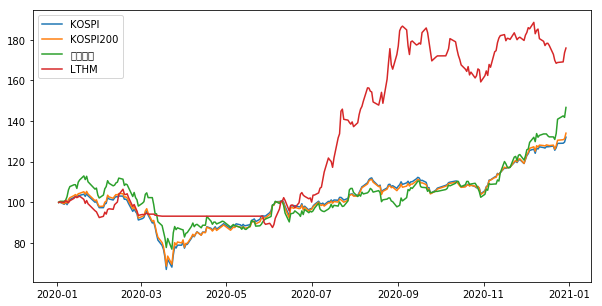

In [157]:
show_chart()

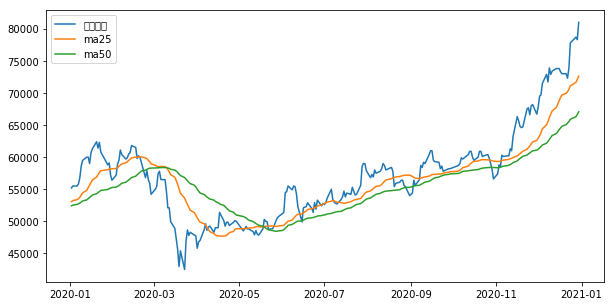

In [59]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)
    
code = "005930.KS"
ticker_data = ticker_list[code]['data']
subplot.plot(ticker_data['Close'], label=ticker_list[code]['stock_name'])
#subplot.plot(ticker_data['ma5'], label='ma5')
subplot.plot(ticker_data['ma25'], label='ma25')
subplot.plot(ticker_data['ma50'], label='ma50')
#subplot.plot(ticker_data['ma100'], label='ma100')
subplot.legend()
plt.show()

In [123]:
#LTHM.is_stop_loss(): code= 000660.KS stock_name= SK하이닉스 buy_price= 94700.0 price= 94500.0 atr20*x= 10350.0

def is_test():
    price = 94500.0
    atr20 = 10350.0/5
    buy_price = 94700.0
    if (price < buy_price):
        print("ok01")
    if ((buy_price-price) < atr20*5):
        print("ok02")
    if (price < buy_price and ((buy_price-price) < atr20*5)):
        print("LTHM.is_stop_loss():", "code=", "stock_name=", \
              "buy_price=", buy_price, "price=", price, "atr20*x=", atr20*5)
        return True
    return False
print (is_test())

ok01
ok02
LTHM.is_stop_loss(): code= stock_name= buy_price= 94700.0 price= 94500.0 atr20*x= 10350.0
True
